In [2]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag

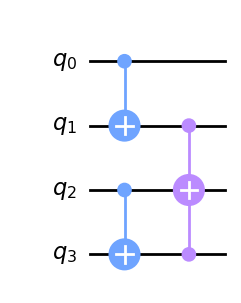

In [3]:
circ = QuantumCircuit(4)

# circ.cx(0, 1)
# circ.cx(1, 2)
circ.cx(0, 1)
circ.cx(2, 3)
circ.ccx(1, 3, 2)

circ.draw("mpl")

In [4]:
from dpqa_simple import DPQA_Simple

In [5]:
dpqa = DPQA_Simple("Name")
dpqa.compile(circ)

optimal solving with 1 step
    no solution, step=1 too small
    found solution with 3 gates in 2 step
runtime 2.8156492710113525


{'name': 'Name',
 'layers': [{'qubits': [{'id': 0, 'a': 0, 'x': 3, 'y': 15, 'c': 1, 'r': 0},
    {'id': 1, 'a': 1, 'x': 3, 'y': 15, 'c': 1, 'r': 2},
    {'id': 2, 'a': 0, 'x': 3, 'y': 14, 'c': 0, 'r': 0},
    {'id': 3, 'a': 1, 'x': 3, 'y': 14, 'c': 0, 'r': 1}],
   'gates': [{'q0': 0, 'q1': 1}, {'q0': 2, 'q1': 3}]},
  {'qubits': [{'id': 0, 'a': 0, 'x': 3, 'y': 15, 'c': 0, 'r': 0},
    {'id': 1, 'a': 1, 'x': 3, 'y': 14, 'c': 1, 'r': 2},
    {'id': 2, 'a': 0, 'x': 3, 'y': 14, 'c': 0, 'r': 0},
    {'id': 3, 'a': 1, 'x': 3, 'y': 14, 'c': 0, 'r': 1}],
   'gates': [{'q0': 1, 'q1': 2, 'q2': 3}]}],
 'timestamp': '1693992516.610682',
 'duration': '2.8156492710113525',
 'n_t': 2}

In [ ]:
for c in dpqa.dpqa.model():
    print(c, dpqa.dpqa.model()[c])

anx_57 False
anx_136 False
anx_24 True
a_q0_t0 False
x_q2_t3 13
anx_78 True
x_q1_t1 14
anx_118 False
anx_40 True
x_q3_t3 13
r_q3_t2 0
anx_120 True
anx_42 False
a_q3_t1 False
anx_65 False
c_q1_t1 2
anx_45 False
r_q2_t2 1
anx_92 True
x_q0_t2 14
anx_48 True
anx_113 True
anx_122 True
anx_28 True
anx_96 True
anx_135 False
anx_134 False
anx_46 True
anx_117 False
c_q3_t0 2
r_q1_t0 2
anx_50 True
anx_74 False
y_q3_t2 7
anx_56 True
y_q1_t3 8
anx_101 False
anx_29 True
anx_87 False
anx_52 True
a_q3_t0 False
c_q0_t0 0
c_q1_t0 2
anx_32 True
anx_71 False
anx_21 False
c_q2_t2 1
anx_80 False
r_q1_t2 2
anx_31 False
anx_97 False
y_q2_t0 8
y_q3_t3 7
anx_121 True
anx_64 False
anx_103 True
anx_34 True
r_q1_t3 2
anx_84 True
c_q0_t1 0
anx_105 False
anx_67 False
anx_110 True
anx_25 False
x_q1_t2 13
anx_44 True
x_q3_t2 13
anx_127 True
a_q1_t2 True
anx_128 True
anx_112 True
t_g1 2
y_q0_t2 8
a_q1_t1 True
x_q1_t3 14
anx_36 True
r_q2_t3 1
anx_115 False
a_q0_t2 False
c_q3_t3 2
t_g0 1
x_q3_t0 13
anx_68 False
y_q3_t0 

In [ ]:
dpqa.result_json

{'name': 'Name',
 'layers': [{'qubits': [{'id': 0, 'a': 0, 'x': 14, 'y': 8, 'c': 0, 'r': 2},
    {'id': 1, 'a': 1, 'x': 14, 'y': 8, 'c': 2, 'r': 2},
    {'id': 2, 'a': 1, 'x': 13, 'y': 8, 'c': 1, 'r': 1},
    {'id': 3, 'a': 0, 'x': 13, 'y': 7, 'c': 0, 'r': 0}],
   'gates': [{'id': [0, 2], 'q0': 0, 'q1': 1}]},
  {'qubits': [{'id': 0, 'a': 0, 'x': 14, 'y': 8, 'c': 1, 'r': 0},
    {'id': 1, 'a': 1, 'x': 13, 'y': 8, 'c': 2, 'r': 2},
    {'id': 2, 'a': 1, 'x': 13, 'y': 8, 'c': 1, 'r': 1},
    {'id': 3, 'a': 0, 'x': 13, 'y': 7, 'c': 2, 'r': 0}],
   'gates': [{'id': [1], 'q0': 1, 'q1': 2}]},
  {'qubits': [{'id': 0, 'a': 0, 'x': 14, 'y': 8, 'c': 2, 'r': 0},
    {'id': 1, 'a': 1, 'x': 14, 'y': 8, 'c': 2, 'r': 2},
    {'id': 2, 'a': 1, 'x': 13, 'y': 7, 'c': 1, 'r': 1},
    {'id': 3, 'a': 0, 'x': 13, 'y': 7, 'c': 2, 'r': 0}],
   'gates': [{'id': [0, 2], 'q0': 0, 'q1': 1},
    {'id': [3], 'q0': 2, 'q1': 3}]}],
 'timestamp': '1690830920.9853063',
 'duration': '42.128520488739014',
 'n_t': 3}

In [ ]:
with open("model.txt", "w") as file:
    for const in dpqa.dpqa.assertions():
        file.write(f"{const}\n")

In [ ]:
from z3 import Optimize, Sum

In [ ]:
opt = Optimize()

In [ ]:
for const in dpqa.dpqa.assertions():
    opt.add(const)

In [ ]:
opt.minimize("x_q0_0")

AttributeError: 'str' object has no attribute 'as_ast'